# Calculating the Big Mac Index

This R script shows how _The Economist_ calculates its Big Mac index.

We use the `tidyverse` and `data.table` packages for working with data generally, and `countrycode` for handling conversions between ISO encoding schemes.

In [1]:
library('tidyverse')
library('data.table')
library('countrycode')

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.5
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



First, we will set up a map of our ISO codes. We start with a CSV that contains a map of currency codes (ISO-4217) to country codes (ISO-3166-1). Our currency map (obtained from https://github.com/srcagency/country-currencies) contains Alpha-2 codes, but the rest of our data uses Alpha 3, so we'll fix that now. We also use an invented country code for the Eurozone, `EUZ`, so we tack that on the end.

In [2]:
currency_map = fread('./source-data/currency-map.csv') %>%
    .[,.(iso_a3 = countrycode(country, 'iso2c', 'iso3c'), currency_code = currency)] %>%
    list(list('EUZ', 'EUR')) %>%
    rbindlist
tail(currency_map)

iso_a3,currency_code
YEM,YER
MYT,EUR
ZAF,ZAR
ZMB,ZMW
ZWE,USD
EUZ,EUR


We only calculate the Big Mac index for certain countries, specifically these ones:

In [3]:
big_mac_countries = c('ARG', 'AUS', 'BRA', 'GBR', 'CAN', 'CHL', 'CHN', 'CZE', 'DNK',
                      'EGY', 'HKG', 'HUN', 'IDN', 'ISR', 'JPN', 'MYS', 'MEX', 'NZL',
                      'NOR', 'PER', 'PHL', 'POL', 'RUS', 'SAU', 'SGP', 'ZAF', 'KOR',
                      'SWE', 'CHE', 'TWN', 'THA', 'TUR', 'ARE', 'USA', 'COL', 'CRI',
                      'PAK', 'LKA', 'UKR', 'URY', 'IND', 'VNM', 'GTM', 'HND', # Venezuela removed
                      'NIC', 'AZE', 'BHR', 'HRV', 'JOR', 'KWT', 'LBN', 'MDA', 'OMN',
                      'QAT', 'ROU', 'EUZ')

Our raw data sheet, compiled every six months, contains three sets of data: the local price of a Big Mac, the exchange rate of the local currency to the US dollar, and the GDP per person of the country (in US dollars). We have these data compiled into a single file already, so we can just load it:

In [4]:
big_mac_data = fread('./source-data/big-mac-source-data.csv', na.strings = '#N/A') %>%
    .[!is.na(local_price)] %>%                    # remove lines where the local price is missing
    .[,GDP_dollar := as.numeric(GDP_dollar)] %>%  # convert GDP to a number
    merge(currency_map, by='iso_a3') %>%          # add currency codes based on country
    .[order(date, name)]                          # sort by date and then by country name, for easy reading
tail(big_mac_data)

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”

iso_a3,name,local_price,dollar_ex,GDP_dollar,date,currency_code
ARE,UAE,14.00,3.67,NA,2018-07-01,AED
UKR,Ukraine,47.00,28.72,NA,2018-07-01,UAH
USA,United States,5.28,1.00,57607.61,2018-07-01,USD
URY,Uruguay,140.00,28.58,NA,2018-07-01,UYU
VEN,Venezuela,0.00,0.00,NA,2018-07-01,VEF
VNM,Vietnam,65000.00,22711.50,NA,2018-07-01,VND


In [5]:
latest_date = big_mac_data$date %>% max

### Converting to a uniform currency

Our first step to calculate the index is to convert all of the prices to a uniform currency (we use the US dollar).

In [6]:
big_mac_data[, dollar_price := local_price / dollar_ex]
tail(big_mac_data)

iso_a3,name,local_price,dollar_ex,GDP_dollar,date,currency_code,dollar_price
ARE,UAE,14.00,3.67,NA,2018-07-01,AED,3.814714
UKR,Ukraine,47.00,28.72,NA,2018-07-01,UAH,1.636490
USA,United States,5.28,1.00,57607.61,2018-07-01,USD,5.280000
URY,Uruguay,140.00,28.58,NA,2018-07-01,UYU,4.898530
VEN,Venezuela,0.00,0.00,NA,2018-07-01,VEF,NaN
VNM,Vietnam,65000.00,22711.50,NA,2018-07-01,VND,2.861986


### Calculating the raw index

Now that we've done this, we can pick out our five 'base' currencies: the US dollar (USD), Euro (EUR), British pound (GBP), Japanese yen (JPY), and Chinese yuan (CNY).

In [7]:
base_currencies = c('USD', 'EUR', 'GBP', 'JPY', 'CNY')

Calculating the index is as simple as dividing the local price by the price in the base currency. We're using `data.table`'s grouping abilities to do this neatly.

In [8]:
big_mac_index = big_mac_data[
    !is.na(dollar_price) & iso_a3 %in% big_mac_countries
    ,.(date, iso_a3, currency_code, name, local_price, dollar_ex, dollar_price)]

for(currency in base_currencies) {
    big_mac_index[
        ,                           # we don't want a subset, so our first argument is blank
        (currency) :=               # we'll add a new column named for the base set
            dollar_price /          # we divide the dollar price in each row by
                                    # the dollar price on the *base currency*'s row (.SD is a data.table
            .SD[currency_code == currency]$dollar_price -        # that contains only the current group)
            1,                      # one means parity (neither over- nor under-valued), so we subtract one
                                    # to get an over/under-valuation value
        by=date                     # and of course, we'll group these rows by date
    ]
}
big_mac_index[, (base_currencies) := round(.SD, 3), .SDcols=base_currencies]
tail(big_mac_index)

date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,USD,EUR,GBP,JPY,CNY
2018-07-01,TUR,TRY,Turkey,10.75,3.80,2.828947,-0.464,-0.413,-0.361,-0.176,-0.108
2018-07-01,ARE,AED,UAE,14.00,3.67,3.814714,-0.278,-0.208,-0.139,0.112,0.202
2018-07-01,UKR,UAH,Ukraine,47.00,28.72,1.636490,-0.690,-0.660,-0.631,-0.523,-0.484
2018-07-01,USA,USD,United States,5.28,1.00,5.280000,0.000,0.096,0.192,0.539,0.664
2018-07-01,URY,UYU,Uruguay,140.00,28.58,4.898530,-0.072,0.017,0.106,0.427,0.544
2018-07-01,VNM,VND,Vietnam,65000.00,22711.50,2.861986,-0.458,-0.406,-0.354,-0.166,-0.098


We can also see a basic plot, like so:

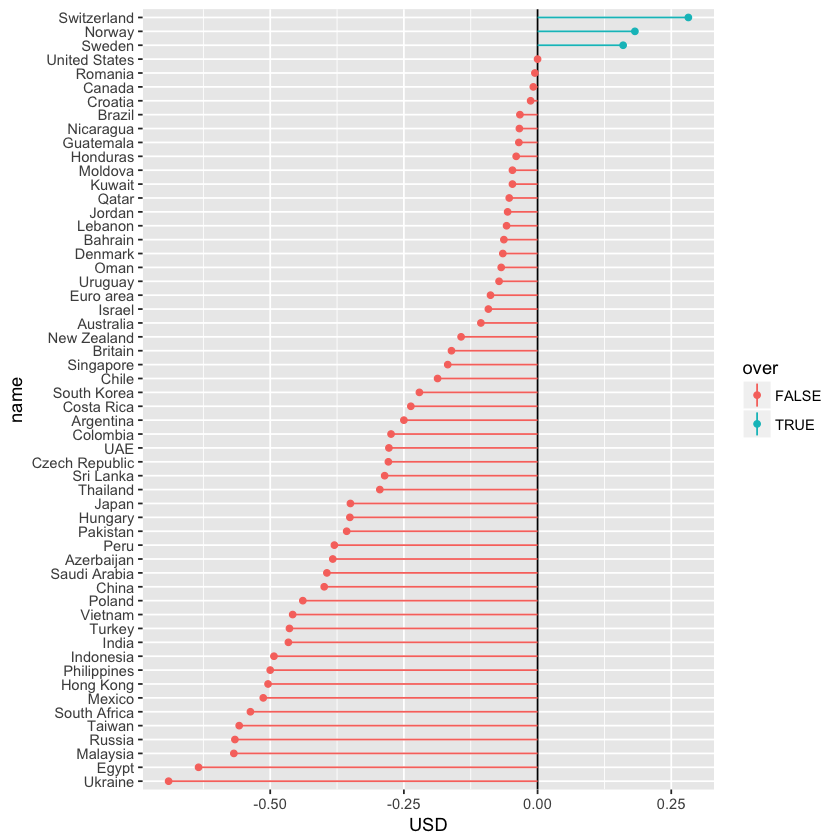

In [10]:
to_plot = big_mac_index[date == latest_date]
to_plot$name = factor(to_plot$name, levels=to_plot$name[order(to_plot$USD)])
ggplot(to_plot[, over := USD > 0], aes(x=name, y=USD, color=over)) +
    geom_hline(yintercept = 0) +
    geom_linerange(aes(ymin=0, ymax=USD)) +
    geom_point() +
    coord_flip()

We've now calculated the index. We'll save it to a file.

In [9]:
fwrite(big_mac_index, './output-data/big-mac-raw-index.csv')

Lovely! We've got it. So what about that adjusted index?

## Calculating the adjusted index

While the Big Mac index is a refreshingly simple way of thinking about relative currency values, a common (and fair) objection to it is that burgers cannot be easily traded across borders. Given non-traded local inputs (rent and worker’s wages) one would expect Big Macs to be cheaper in poorer countries and dearer in wealthier ones.

We'll start out by only picking the countries where we have GDP data.

In [11]:
big_mac_gdp_data = big_mac_data[GDP_dollar > 0]
head(big_mac_gdp_data)

iso_a3,name,local_price,dollar_ex,GDP_dollar,date,currency_code,dollar_price
ARG,Argentina,20.00,4.13,9138.18,2011-07-01,ARS,4.842615
AUS,Australia,4.56,0.92,55589.55,2011-07-01,AUD,4.956522
AUT,Austria,3.09,0.70,44986.58,2011-07-01,EUR,4.414286
BEL,Belgium,3.75,0.70,42630.11,2011-07-01,EUR,5.357143
BRA,Brazil,9.50,1.54,10816.49,2011-07-01,BRL,6.168831
GBR,Britain,2.39,0.61,36119.85,2011-07-01,GBP,3.918033


In order to correct for the problem, we'll use a linear regression of GDP vs Big Mac Price. That looks something like this:

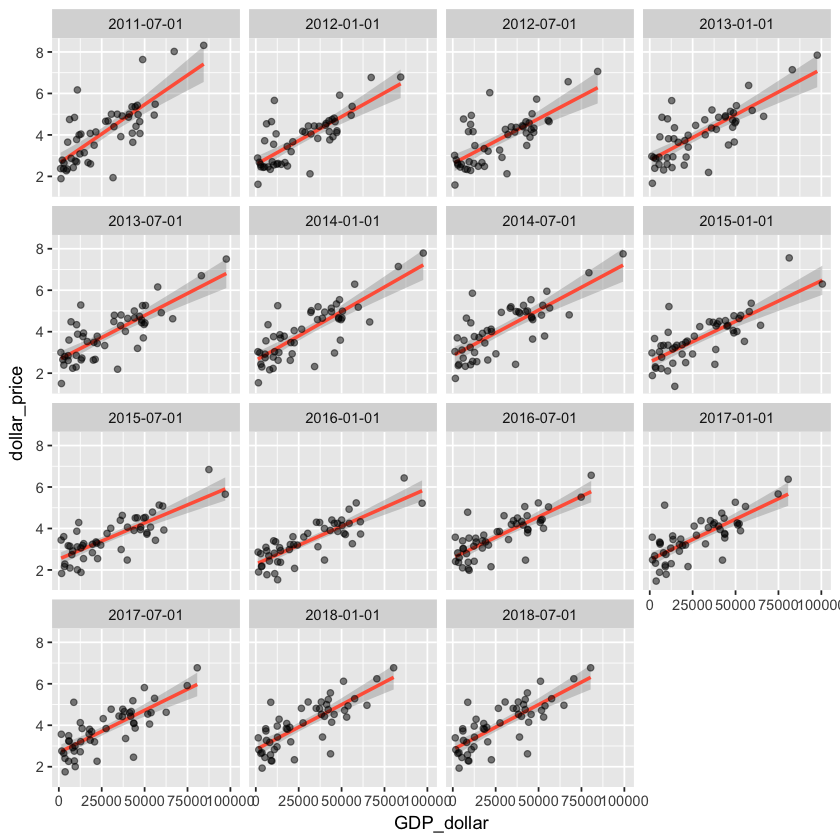

In [12]:
ggplot(big_mac_gdp_data, aes(x=GDP_dollar, y=dollar_price)) +
    facet_wrap(~date) +
    geom_smooth(method = lm, color='tomato') +
    geom_point(alpha=0.5)

We have to calculate the regressions separately for each date, of course.

In [13]:
big_mac_gdp_data[,adj_price := lm(dollar_price ~ GDP_dollar) %>% predict,by=date]
head(big_mac_gdp_data)

iso_a3,name,local_price,dollar_ex,GDP_dollar,date,currency_code,dollar_price,adj_price
ARG,Argentina,20.00,4.13,9138.18,2011-07-01,ARS,4.842615,3.148278
AUS,Australia,4.56,0.92,55589.55,2011-07-01,AUD,4.956522,5.781812
AUT,Austria,3.09,0.70,44986.58,2011-07-01,EUR,4.414286,5.180683
BEL,Belgium,3.75,0.70,42630.11,2011-07-01,EUR,5.357143,5.047084
BRA,Brazil,9.50,1.54,10816.49,2011-07-01,BRL,6.168831,3.243429
GBR,Britain,2.39,0.61,36119.85,2011-07-01,GBP,3.918033,4.677988


If we've done everything right, all the points we just generated should be on those lines from above...

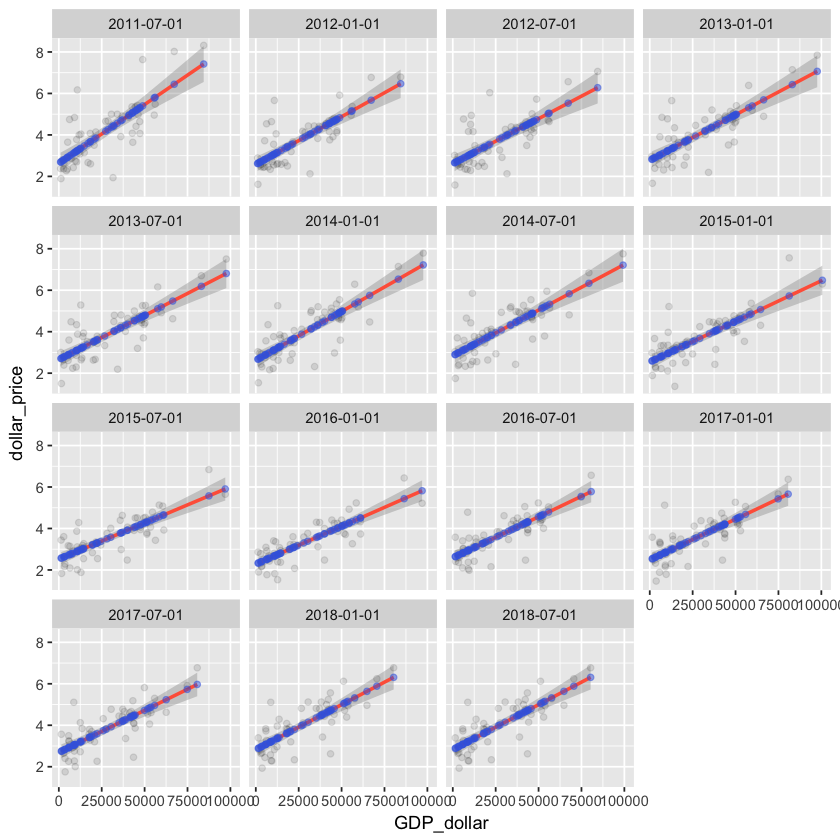

In [14]:
ggplot(big_mac_gdp_data, aes(x=GDP_dollar, y=dollar_price)) +
    facet_wrap(~date) +
    geom_smooth(method = lm, color='tomato') +
    geom_point(alpha=0.1) +
    geom_point(aes(y=adj_price), color='royalblue', alpha=0.5)

Yep, that's exactly what we wanted. So now that we've got these data, we can do almost the same thing as before.

In [15]:
big_mac_adj_index = big_mac_gdp_data[
    !is.na(dollar_price) & iso_a3 %in% big_mac_countries
    ,.(date, iso_a3, currency_code, name, local_price, dollar_ex, dollar_price, GDP_dollar, adj_price)]

for(currency in base_currencies) {
    big_mac_adj_index[
        ,                           # we don't want a subset, so our first argument is blank
        (currency) :=               # we'll add a new column named for the base set
            (                       # we divide the dollar price by the adjusted price to get
                dollar_price / adj_price  # the deviation from our expectation by
            ) /
                                    # the same figure from the *base currency*'s row
            (
                .SD[currency_code == currency]$dollar_price /
                .SD[currency_code == currency]$adj_price
            ) -
            1,                      # one means parity (neither over- nor under-valued), so we subtract one
                                    # to get an over/under-valuation value
        by=date                     # and of course, we'll group these rows by date
    ]
}
big_mac_adj_index[, (base_currencies) := round(.SD, 3), .SDcols=base_currencies]

tail(big_mac_adj_index)

date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,GDP_dollar,adj_price,USD,EUR,GBP,JPY,CNY
2018-07-01,SWE,SEK,Sweden,49.10,8.02,6.122195,51124.76,5.042283,0.224,0.097,0.250,0.596,0.216
2018-07-01,CHE,CHF,Switzerland,6.50,0.96,6.770833,80345.62,6.310313,0.082,-0.031,0.105,0.410,0.074
2018-07-01,TWN,TWD,Taiwan,69.00,29.55,2.335025,22497.00,3.799991,-0.380,-0.445,-0.367,-0.192,-0.385
2018-07-01,THA,THB,Thailand,119.00,31.95,3.724570,5901.75,3.079846,0.219,0.092,0.245,0.590,0.211
2018-07-01,TUR,TRY,Turkey,10.75,3.80,2.828947,10817.41,3.293159,-0.134,-0.224,-0.116,0.129,-0.140
2018-07-01,USA,USD,United States,5.28,1.00,5.280000,57607.61,5.323605,0.000,-0.104,0.021,0.304,-0.007


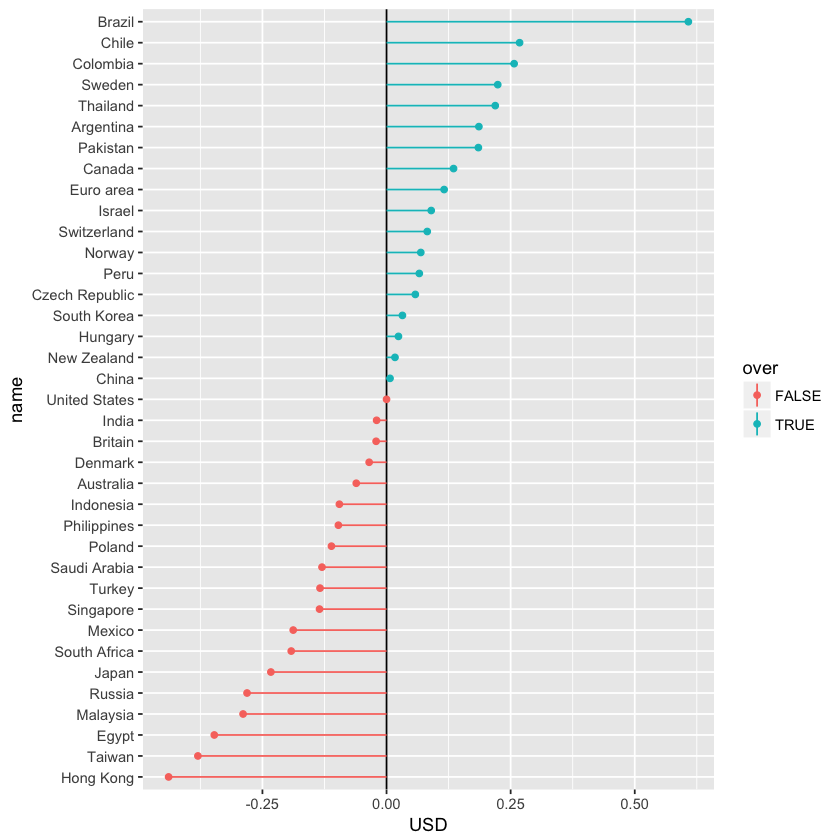

In [16]:
to_plot = big_mac_adj_index[date == latest_date]
to_plot$name = factor(to_plot$name, levels=to_plot$name[order(to_plot$USD)])
ggplot(to_plot[, over := USD > 0], aes(x=name, y=USD, color=over)) +
    geom_hline(yintercept = 0) +
    geom_linerange(aes(ymin=0, ymax=USD)) +
    geom_point() +
    coord_flip()

In [17]:
fwrite(big_mac_adj_index, './output-data/big-mac-adjusted-index.csv')

Also, for tidiness, we'll generate a consolidated file with both indices in one table.

In [18]:
big_mac_full_index = merge(big_mac_index, big_mac_adj_index,
      by=c('date', 'iso_a3', 'currency_code', 'name', 'local_price', 'dollar_ex', 'dollar_price'),
      suffixes=c('_raw', '_adjusted'),
      all.x=TRUE
     )
tail(big_mac_full_index)

date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,USD_raw,EUR_raw,GBP_raw,JPY_raw,CNY_raw,GDP_dollar,adj_price,USD_adjusted,EUR_adjusted,GBP_adjusted,JPY_adjusted,CNY_adjusted
2018-07-01,TWN,TWD,Taiwan,69.00,29.55,2.335025,-0.558,-0.515,-0.473,-0.320,-0.264,22497.00,3.799991,-0.380,-0.445,-0.367,-0.192,-0.385
2018-07-01,UKR,UAH,Ukraine,47.00,28.72,1.636490,-0.690,-0.660,-0.631,-0.523,-0.484,NA,NA,NA,NA,NA,NA,NA
2018-07-01,URY,UYU,Uruguay,140.00,28.58,4.898530,-0.072,0.017,0.106,0.427,0.544,NA,NA,NA,NA,NA,NA,NA
2018-07-01,USA,USD,United States,5.28,1.00,5.280000,0.000,0.096,0.192,0.539,0.664,57607.61,5.323605,0.000,-0.104,0.021,0.304,-0.007
2018-07-01,VNM,VND,Vietnam,65000.00,22711.50,2.861986,-0.458,-0.406,-0.354,-0.166,-0.098,NA,NA,NA,NA,NA,NA,NA
2018-07-01,ZAF,ZAR,South Africa,30.00,12.26,2.446982,-0.537,-0.492,-0.448,-0.287,-0.229,5302.04,3.053821,-0.192,-0.276,-0.175,0.053,-0.198


In [19]:
fwrite(big_mac_full_index, './output-data/big-mac-full-index.csv')